In [1]:
import pandas as pd
import numpy as np
from itertools import combinations

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import scipy.stats as stats
from scipy.stats import pearsonr, norm, ttest_ind, t, ttest_1samp

c:\Users\agust\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\agust\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Percentage of economic inequality topics in the Congress and NYT

Yearly calculation and visualization of the proportion of articles and speeches that were related to economic inequality (compared with total from each dataset)

#### USA Congress

In [2]:
#Total speeches per year
#with open('1_congress_data_proc/python_objects/total_speeches_per_year.pkl', 'rb') as f:
#    total_speeches_per_year = pickle.load(f)
total_speeches_per_year = pd.read_pickle('1_congress_data_proc/python_objects/total_speeches_per_year.pkl')


In [3]:
total_speeches_per_year[-11:]

year
2014    23999
2015    34813
2016    28144
2017    32348
2018    27094
2019    29075
2020    20343
2021    21034
2022    21392
2023    22838
2024    21270
dtype: int64

In [4]:
#Dataset on speeches on economic inequality
speeches_econ_ineq = pd.read_csv('1_congress_data_proc/python_objects/congress39_econ_ineq_2401.csv')
#Definition of "economic inequality" as in NYT query
speeches_econ_ineq = speeches_econ_ineq[speeches_econ_ineq["pattern_match_within_window"] == True]

In [5]:
#Proportion calculation
speeches_ineq_per_year = speeches_econ_ineq.groupby('year', group_keys=False).size()
proportion_speeches_ineq_yearly = speeches_ineq_per_year / total_speeches_per_year  * 100

In [6]:
proportion_speeches_ineq_yearly.to_csv("economic_data/proportion_speeches_ineq_yearly.csv", index=True)

In [7]:
print("Sum for:", speeches_ineq_per_year.sum())
# Filter speeches from 1980 onward
speeches_from_1980 = speeches_ineq_per_year[speeches_ineq_per_year.index >= 1980]

# Count total speeches from 1980 onward
total_speeches_from_1980 = speeches_from_1980.sum()
print("Sum from 1980:", speeches_from_1980.sum())

#Sum for: 5270
#Sum from 1980: 3777

Sum for: 5270
Sum from 1980: 3777


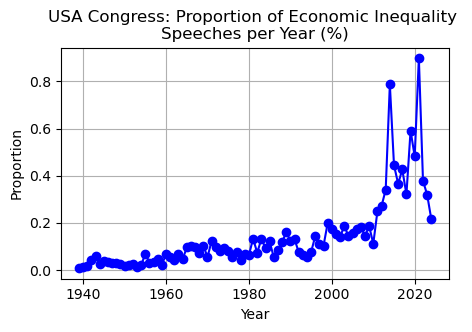

In [8]:
plt.figure(figsize=(5, 3))
plt.plot(proportion_speeches_ineq_yearly.index, proportion_speeches_ineq_yearly.values, marker='o', linestyle='-', color='b')
plt.title('USA Congress: Proportion of Economic Inequality \nSpeeches per Year (%)')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.grid(True)
plt.show()

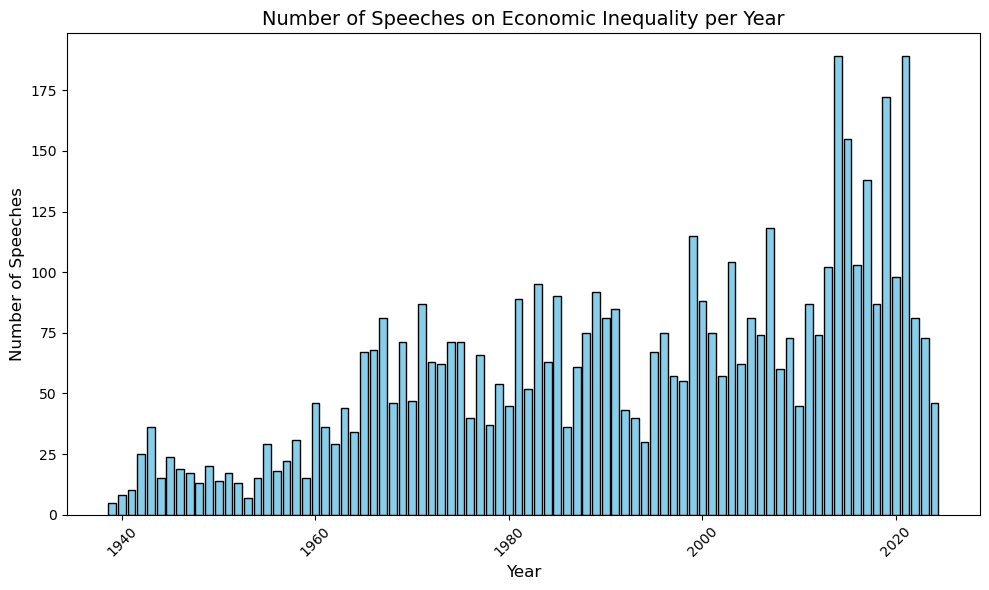

In [9]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(speeches_ineq_per_year.index, speeches_ineq_per_year.values, color='skyblue', edgecolor='black')

# Customizing the plot
plt.title('Number of Speeches on Economic Inequality per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Speeches', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.tight_layout()

# Show the plot
plt.show()

#### NYT

In [10]:
#Total articles per year
total_articles_per_year = pd.read_csv('1_nyt_ineq_articles/python_objects/yearly_counts_nyt_non_ineq_articles.csv')

In [11]:
#with open("1_nyt_ineq_articles/python_objects/articles_ineq_per_year_no_noise.pkl", 'rb') as f: 
#    articles_ineq_per_year = pickle.load(f)

articles_ineq_per_year = pd.read_pickle('1_nyt_ineq_articles/python_objects/articles_ineq_per_year_no_noise.pkl')


In [12]:
#Proportion calculation
proportion_articles_ineq_yearly = articles_ineq_per_year / total_articles_per_year.set_index('year')['total_article_count'] * 100

In [13]:
proportion_articles_ineq_yearly.to_csv("economic_data/proportion_articles_ineq_yearly.csv", index=True)

In [14]:
articles_ineq_per_year.sum()
#11365

11305

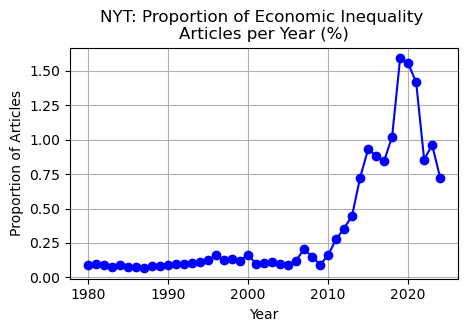

In [15]:
# Step 3: Plot the results
plt.figure(figsize=(5, 3))
plt.plot(proportion_articles_ineq_yearly.index, proportion_articles_ineq_yearly.values, marker='o', linestyle='-', color='b')
plt.title('NYT: Proportion of Economic Inequality \nArticles per Year (%)')
plt.xlabel('Year')
plt.ylabel('Proportion of Articles')
plt.grid(True)
plt.show()


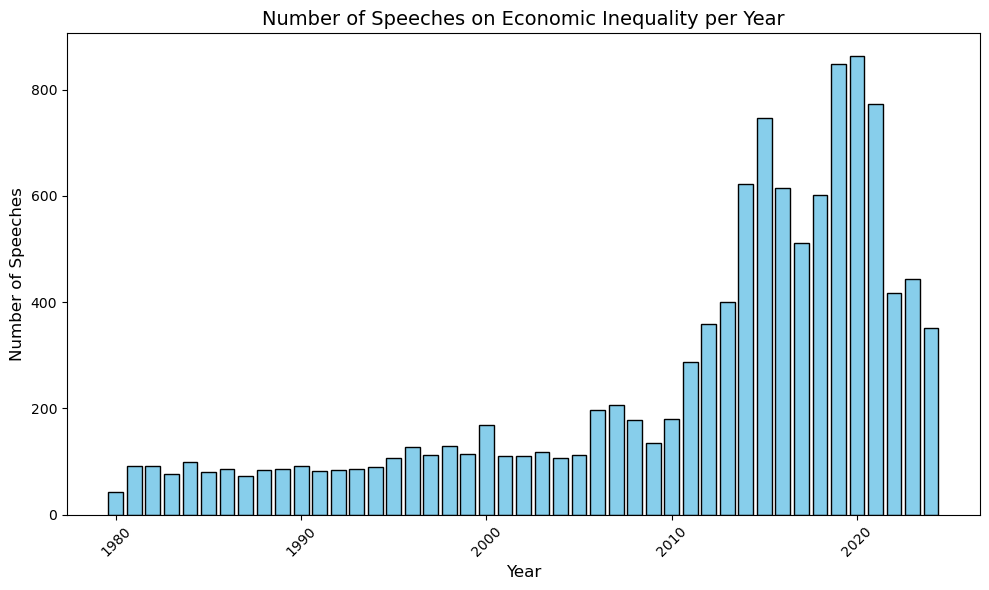

In [16]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(articles_ineq_per_year.index, articles_ineq_per_year.values, color='skyblue', edgecolor='black')

# Customizing the plot
plt.title('Number of Speeches on Economic Inequality per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Speeches', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.tight_layout()

# Show the plot
plt.show()

#### Joint graph

In [17]:
def plot_ineq_coverage(proportion_speeches_ineq_yearly, proportion_articles_ineq_yearly, output_path=""):
    # Combine data into a single DataFrame
    data = pd.DataFrame({
        'Year': list(proportion_speeches_ineq_yearly.index) + list(proportion_articles_ineq_yearly.index),
        'Proportion': list(proportion_speeches_ineq_yearly.values) + list(proportion_articles_ineq_yearly.values),
        'Dataset': ['USA Congress'] * len(proportion_speeches_ineq_yearly) +
                  ['NYT articles'] * len(proportion_articles_ineq_yearly)
    })

    data = data[data['Year'] >= 1980]

    # Define US presidents and their party colors
    presidents = [
        (1981, 1989, "Republican", "Reagan"),
        (1989, 1993, "Republican", "Bush Sr."),
        (1993, 2001, "Democrat", "Clinton"),
        (2001, 2009, "Republican", "Bush Jr."),
        (2009, 2017, "Democrat", "Obama"),
        (2017, 2021, "Republican", "Trump"),
        (2021, 2024, "Democrat", "Biden")
    ]

    party_colors = {"Republican": "#C70039", "Democrat": "#1F77B4"}  # Red for Republicans, Blue for Democrats

    # Define major economic events
    events = {
        2007: "Great <br>Recession",
        2011: "Occupy <br>Movement",
        2020: "COVID-19"
    }

    # Create figure
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

    # Add vertical transition lines & president names with color coding
    for start, end, party, name in presidents:
        if start > 1980:
            fig.add_shape(
                type="line",
                x0=start, x1=start,
                y0=0, y1=2.3,  # Presidential transition lines up to 2.3
                line=dict(color="black", dash="dash", width=1)
            )
        
        # Add president's name at 2.0 height with color coding
        fig.add_annotation(
            x=(start + end) / 2,  # Center text in the period
            y=2.0,  # Position at 2% height of y-axis
            text=f"<span style='color:{party_colors[party]};'>{name}</span>",
            showarrow=False,
            font=dict(size=12),
            yshift=5
        )

    # Add vertical lines for major events
    for year, label in events.items():
        fig.add_shape(
            type="line",
            x0=year, x1=year,
            y0=0, y1=2.4,  # Event lines up to 2.4
            line=dict(color="black", dash="dot", width=2)
        )
        fig.add_annotation(
            x=year, y=2.5,  # Adjust position
            text=label,
            showarrow=False,
            font=dict(size=12, color="black"),
            yshift=10
        )

        # Add traces for NYT Articles and Congress Speeches
    fig.add_trace(
        go.Scatter(
            x=data[data['Dataset'] == 'NYT articles']['Year'],
            y=data[data['Dataset'] == 'NYT articles']['Proportion'],
            mode='lines',
            name='NYT Articles',
            line=dict(width=3, color='#FFB347'),
            hoverinfo="x+y+name",
            hovertemplate='<b>NYT Articles</b><br>Proportion: %{y:.2f}%<extra></extra>',
            legendgroup='NYT Articles',
            showlegend=True
        )
    )

    fig.add_trace(
        go.Scatter(
            x=data[data['Dataset'] == 'USA Congress']['Year'],
            y=data[data['Dataset'] == 'USA Congress']['Proportion'],
            mode='lines',
            name='USA Congress',
            line=dict(width=3, color='#77966D'),
            hoverinfo="x+y+name",
            hovertemplate='<b>USA Congress</b><br>Proportion: %{y:.2f}%<extra></extra>',
            legendgroup='USA Congress'
        )
    )

    fig.update_layout(
    title_text='Economic Inequality: USA Congress Speeches and NYT Articles<br>Yearly Coverage as Percentage',
    title_x=0.5,
    title_y=0.9,
    font=dict(family="Helvetica, sans-serif", size=14, color="black"),
    legend=dict(orientation='h', x=0.5, xanchor='center', y=1.2, font=dict(size=14)),
    xaxis=dict(
        title='Year',
        range=[1980, 2024],  # Keep the range ending at 2024
        tickvals=list(range(1980, 2025, 4)) + [2024],  # Ensure 2024 is included in the tick marks
        showline=True, 
        linecolor='black', 
        ticks="outside", 
        gridcolor="#e8e8e8"
    ),
    yaxis=dict(
        title='Percentage (%)',
        range=[0, 3],
        ticks="outside", 
        showline=True, 
        linecolor='black', 
        gridcolor="#e8e8e8",
        tickformat=".1f"
    ),
    template='simple_white',
    hovermode="x unified",
    margin=dict(t=140)
)


    fig.show()

    if output_path:
        output_path = "graphs/"+ output_path
        fig.write_html(output_path)


In [18]:
plot_ineq_coverage(proportion_speeches_ineq_yearly, proportion_articles_ineq_yearly, output_path= "coverage_graph.html")

In [19]:
def plot_ineq_coverage_static(proportion_speeches_ineq_yearly, proportion_articles_ineq_yearly, output_path=""):

    plt.rcParams['font.family'] = 'Times New Roman'


    # Combine data into a single DataFrame
    data = pd.DataFrame({
        'Year': list(proportion_speeches_ineq_yearly.index) + list(proportion_articles_ineq_yearly.index),
        'Proportion': list(proportion_speeches_ineq_yearly.values) + list(proportion_articles_ineq_yearly.values),
        'Dataset': ['USA Congress'] * len(proportion_speeches_ineq_yearly) +
                   ['NYT articles'] * len(proportion_articles_ineq_yearly)
    })
    
    data = data[data['Year'] >= 1980]

    # Define US presidents and their party colors
    presidents = [
        (1981, 1989, "Republican", "Reagan"),
        (1989, 1993, "Republican", "Bush Sr."),
        (1993, 2001, "Democrat", "Clinton"),
        (2001, 2009, "Republican", "Bush Jr."),
        (2009, 2017, "Democrat", "Obama"),
        (2017, 2021, "Republican", "Trump"),
        (2021, 2024, "Democrat", "Biden")
    ]
    
    party_colors = {"Republican": "#C70039", "Democrat": "#1F77B4"}  # Red for Republicans, Blue for Democrats

    # Define major economic events
    events = {
        2007: "GR",
        2011: "OWS",
        2020: "COVID-19"
    }

    # Create figure
    # Create figure with size based on LaTeX's linewidth
    fig_width_inch = 6.5  # Typical figure width for LaTeX
    fig_height_inch = 4   # Adjust to maintain aspect ratio
    fig, ax = plt.subplots(figsize=(fig_width_inch, fig_height_inch))
    #plt.figure(figsize=(fig_width_inch, fig_height_inch))
    
    # Add vertical lines for major events
    linestyle = (0, (1, 2))  # Different dashed styles
    for i, (year, label) in enumerate(events.items()):
        ax.axvline(x=year, color='grey', linestyle=linestyle, linewidth=1.5, ymax=0.86)
        ax.text(year, 2.65, label, ha='center', fontsize=10)
        
    # Add vertical transition lines & president names with color coding
    for start, end, party, name in presidents:
        if start > 1980:
            ax.axvline(x=start, color='black', linestyle=(0, (3, 5)), linewidth=1, ymax=0.8)
        ax.text((start + end) / 2, 2.1, name, color=party_colors[party], ha='center', fontsize=9)#, fontweight='bold')
    
    # Plot data
    congress_data = data[data['Dataset'] == 'USA Congress']
    nyt_data = data[data['Dataset'] == 'NYT articles']
    
    ax.plot(congress_data['Year'], congress_data['Proportion'], label='USA Congress', color='#77966D', linewidth=2)
    ax.plot(nyt_data['Year'], nyt_data['Proportion'], label='NYT Articles', color='#FFB347', linewidth=2)
    
    # Labels and layout
    ax.set_title('Economic inequality yearly coverage percentages \nfor US Congress speeches and NYT articles', fontsize=12, pad=30, loc='center',  fontweight='bold')
    ax.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
    ax.set_xlim(1980, 2024)
    ax.set_ylim(0, 3)
    ax.set_xticks(np.arange(1980, 2025, 4))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
    #ax.grid(True, linestyle='--', alpha=0.6)
    
    # Remove upper and right axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save or show plot
    if output_path:
        output_path = "graphs/"+ output_path
        plt.savefig(output_path, bbox_inches='tight')
    plt.show()

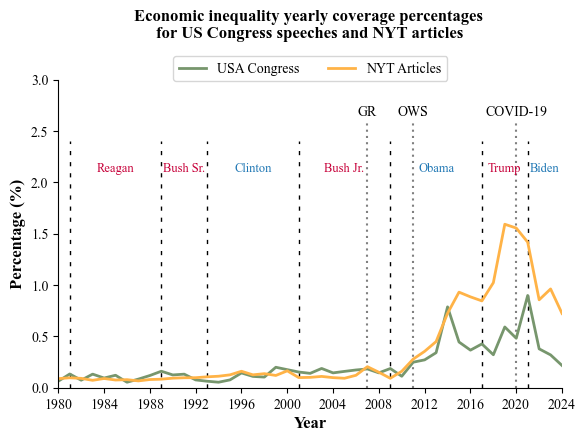

In [20]:
plot_ineq_coverage_static(proportion_speeches_ineq_yearly, proportion_articles_ineq_yearly, output_path= "coverage_graph_static")

In [21]:
proportion_articles_ineq_yearly= proportion_articles_ineq_yearly.reset_index()
proportion_speeches_ineq_yearly = proportion_speeches_ineq_yearly.reset_index()

proportion_articles_ineq_yearly = proportion_articles_ineq_yearly[proportion_articles_ineq_yearly["year"] >1979].rename(columns={0: "article_proportion"})
proportion_speeches_ineq_yearly = proportion_speeches_ineq_yearly[proportion_speeches_ineq_yearly["year"] >1979].rename(columns={0: "speech_proportion"})

In [22]:
# Merge the two datasets on 'year'
coverage_merged = pd.merge(
    proportion_speeches_ineq_yearly,
    proportion_articles_ineq_yearly,
    on="year",
    how="inner"
)

# Define the correlation function with CI and p-value
def pearsonr_ci_with_p(x, y, alpha=0.05):
    r, p = pearsonr(x, y)
    n = len(x)
    if n < 4:
        return r, np.nan, np.nan, p
    z = 0.5 * np.log((1 + r) / (1 - r))  # Fisher z-transform
    se = 1 / np.sqrt(n - 3)
    z_crit = norm.ppf(1 - alpha / 2)
    z_lower = z - z_crit * se
    z_upper = z + z_crit * se
    ci_lower = np.tanh(z_lower)
    ci_upper = np.tanh(z_upper)
    return r, ci_lower, ci_upper, p

# Apply to the merged coverage data
r, ci_low, ci_high, p = pearsonr_ci_with_p(
    coverage_merged["speech_proportion"],
    coverage_merged["article_proportion"]
)

# Print the result
print(f"Coverage correlation (Speech vs Article): r = {r:.3f}, 95% CI [{ci_low:.3f}, {ci_high:.3f}], p = {p:.4f}")


Coverage correlation (Speech vs Article): r = 0.844, 95% CI [0.733, 0.912], p = 0.0000


Trend along time before 2011

In [23]:
# Filter to years before 2011
articles_pre2011 = proportion_articles_ineq_yearly[proportion_articles_ineq_yearly["year"] < 2011]
speeches_pre2011 = proportion_speeches_ineq_yearly[proportion_speeches_ineq_yearly["year"] < 2011]

In [24]:
# Function to compute correlation with CI and p-value
def pearsonr_ci_with_p(x, y, alpha=0.05):
    r, p = pearsonr(x, y)
    n = len(x)
    if n < 4:
        return r, np.nan, np.nan, p
    z = 0.5 * np.log((1 + r) / (1 - r))  # Fisher z-transform
    se = 1 / np.sqrt(n - 3)
    z_crit = norm.ppf(1 - alpha / 2)
    z_lower = z - z_crit * se
    z_upper = z + z_crit * se
    ci_lower = np.tanh(z_lower)
    ci_upper = np.tanh(z_upper)
    return r, ci_lower, ci_upper, p

In [25]:
# 1. Article vs Year
r_article, ci_low_article, ci_high_article, p_article = pearsonr_ci_with_p(
    articles_pre2011["year"], articles_pre2011["article_proportion"]
)
print(f"Article vs Year: r = {r_article:.3f}, 95% CI [{ci_low_article:.3f}, {ci_high_article:.3f}], p = {p_article:.4f}")

# 2. Speech vs Year
r_speech, ci_low_speech, ci_high_speech, p_speech = pearsonr_ci_with_p(
    speeches_pre2011["year"], speeches_pre2011["speech_proportion"]
)
print(f"Speech vs Year: r = {r_speech:.3f}, 95% CI [{ci_low_speech:.3f}, {ci_high_speech:.3f}], p = {p_speech:.4f}")


Article vs Year: r = 0.613, 95% CI [0.330, 0.795], p = 0.0002
Speech vs Year: r = 0.580, 95% CI [0.285, 0.775], p = 0.0006


Datasets differences analysis

In [26]:
# Merge on 'year'
comparison_df = pd.merge(
    proportion_speeches_ineq_yearly[['year', 'speech_proportion']],
    proportion_articles_ineq_yearly[['year', 'article_proportion']],
    on='year',
    how='inner'  # use 'outer' if you want to keep all years even if missing
)

# Calculate the gap and absolute gap
comparison_df['gap'] = comparison_df['article_proportion'] - comparison_df['speech_proportion']
comparison_df['abs_gap'] = comparison_df['gap'].abs()


In [27]:
def plot_gap_boxplot(df, col_name="gap", year_col="year", pivot_year=2014,
                     title="Differences in coverage", y_label="Gap",
                     output_path=""):
    """
    Create a boxplot comparing values before and after a pivot year,
    including mean markers and annotated outliers.

    Parameters:
        df (pd.DataFrame): The input dataframe with a year column and a variable to compare.
        col_name (str): Column name for the variable to compare (e.g., 'gap').
        year_col (str): Column name representing the year.
        pivot_year (int): The year to split the data (default: 2014).
        title (str): Title of the plot.
        y_label (str): Y-axis label.
        output_path (str): File path to save the plot as PNG.
    """

    # Set font
    plt.rcParams['font.family'] = 'Times New Roman'

    # Create figure
    fig, ax = plt.subplots(figsize=(6.5, 4))

    # Subset and clean data
    before = df[df[year_col] <= pivot_year][[year_col, col_name]].dropna()
    after = df[df[year_col] > pivot_year][[year_col, col_name]].dropna()

    # Calculate means
    mean_before = before[col_name].mean()
    mean_after = after[col_name].mean()

    # Boxplot data
    data = [before[col_name], after[col_name]]
    labels = [f"1980–{pivot_year}", f"{pivot_year+1}–2024"]

    # Create boxplot
    ax.boxplot(data, labels=labels,
               flierprops=dict(marker='o', color='black', markersize=6),
               medianprops=dict(color='black', linewidth=1))

    # Annotate outliers with year
    for i, group in enumerate([before, after], start=1):
        q1 = group[col_name].quantile(0.25)
        q3 = group[col_name].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = group[(group[col_name] < lower_bound) | (group[col_name] > upper_bound)]
        for _, row in outliers.iterrows():
            ax.text(i + 0.05, row[col_name], str(int(row[year_col])),
                    fontsize=9, color="black", va='center')

    # Plot mean markers
    ax.plot(1, mean_before, 'ko', markersize=4)
    ax.plot(2, mean_after, 'ko', markersize=4)

    # Decorate
    ax.set_title(title, pad=15)
    ax.set_ylabel(y_label)
    ax.grid(True, axis='y')
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


In [28]:
def analyze_gap_statistics(df, col_name="gap", year_col="year", pivot_year=2014):
    """
    Performs t-tests, confidence intervals, and Cohen's d on a gap variable
    split before and after a pivot year.

    Parameters:
        df (pd.DataFrame): Input DataFrame with a year column and a gap column.
        col_name (str): Name of the column to analyze.
        year_col (str): Name of the column with year values.
        pivot_year (int): Year that divides the two periods.
    """

    before = df[df[year_col] <= pivot_year][col_name].dropna()
    after = df[df[year_col] > pivot_year][col_name].dropna()

    # --- One-sample t-tests (test if mean ≠ 0) ---
    print("One-sample t-tests (test if mean ≠ 0):")
    t_b, p_b = ttest_1samp(before, popmean=0)
    t_a, p_a = ttest_1samp(after, popmean=0)
    print(f"  Before {pivot_year}: t = {t_b:.2f}, p = {p_b:.4f}")
    print(f"  After {pivot_year}:  t = {t_a:.2f}, p = {p_a:.4f}\n")

    # --- Two-sample Welch’s t-test ---
    t_stat, p_val = ttest_ind(before, after, equal_var=False)
    mean_diff = before.mean() - after.mean()
    se_diff = np.sqrt(before.var(ddof=1)/len(before) + after.var(ddof=1)/len(after))

    n1, n2 = len(before), len(after)
    df_welch = (before.var(ddof=1)/n1 + after.var(ddof=1)/n2)**2 / \
               ((before.var(ddof=1)**2)/((n1**2)*(n1-1)) + (after.var(ddof=1)**2)/((n2**2)*(n2-1)))

    ci_range = t.ppf(0.975, df_welch) * se_diff
    ci_low, ci_high = mean_diff - ci_range, mean_diff + ci_range

    print("Two-sample Welch t-test:")
    print(f"  t = {t_stat:.2f}, p = {p_val:.4f}")
    print(f"  Mean diff = {mean_diff:.2f} (95% CI: {ci_low:.2f}, {ci_high:.2f})\n")

    # --- Confidence intervals for each group ---
    def mean_ci(data, conf=0.95):
        n = len(data)
        mean = np.mean(data)
        se = np.std(data, ddof=1) / np.sqrt(n)
        t_crit = t.ppf((1 + conf) / 2, df=n - 1)
        return mean, mean - t_crit * se, mean + t_crit * se

    m_b, ci_b_low, ci_b_high = mean_ci(before)
    m_a, ci_a_low, ci_a_high = mean_ci(after)

    print("Confidence intervals for group means:")
    print(f"  Before {pivot_year}: Mean = {m_b:.2f}, 95% CI = [{ci_b_low:.2f}, {ci_b_high:.2f}]")
    print(f"  After {pivot_year}:  Mean = {m_a:.2f}, 95% CI = [{ci_a_low:.2f}, {ci_a_high:.2f}]\n")

    # --- Cohen's d ---
    pooled_sd = np.sqrt(((n1 - 1)*np.var(before, ddof=1) + (n2 - 1)*np.var(after, ddof=1)) / (n1 + n2 - 2))
    cohen_d = mean_diff / pooled_sd
    print(f"Cohen's d: {cohen_d:.3f}")


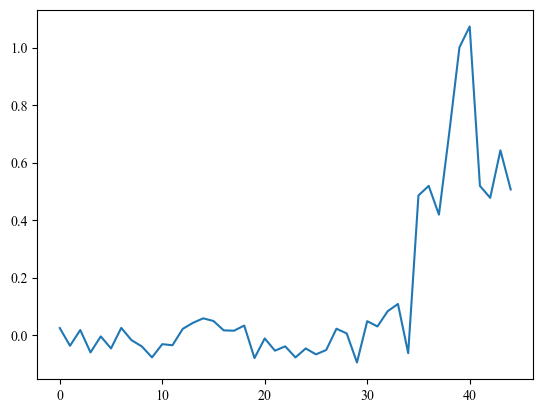

In [29]:
plt.plot(comparison_df["gap"])

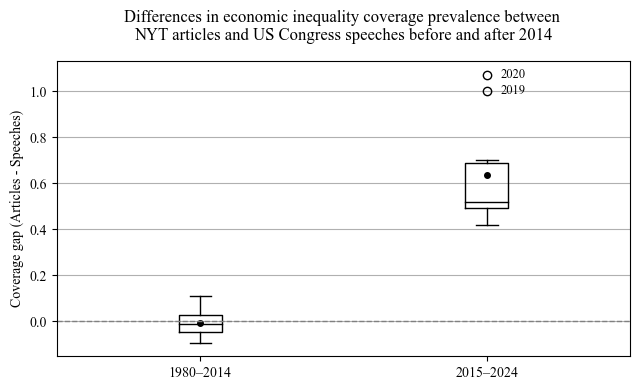

In [30]:
plot_gap_boxplot(
    df=comparison_df,
    col_name="gap",
    pivot_year=2014,
    title="Differences in economic inequality coverage prevalence between \nNYT articles and US Congress speeches before and after 2014",
    y_label="Coverage gap (Articles - Speeches)",
    output_path="graphs/gap_difference_boxplot.png"
)


In [31]:
analyze_gap_statistics(comparison_df, col_name="gap", year_col="year", pivot_year=2014)


One-sample t-tests (test if mean ≠ 0):
  Before 2014: t = -1.11, p = 0.2768
  After 2014:  t = 8.80, p = 0.0000

Two-sample Welch t-test:
  t = -8.87, p = 0.0000
  Mean diff = -0.64 (95% CI: -0.81, -0.48)

Confidence intervals for group means:
  Before 2014: Mean = -0.01, 95% CI = [-0.03, 0.01]
  After 2014:  Mean = 0.63, 95% CI = [0.47, 0.80]

Cohen's d: -5.670


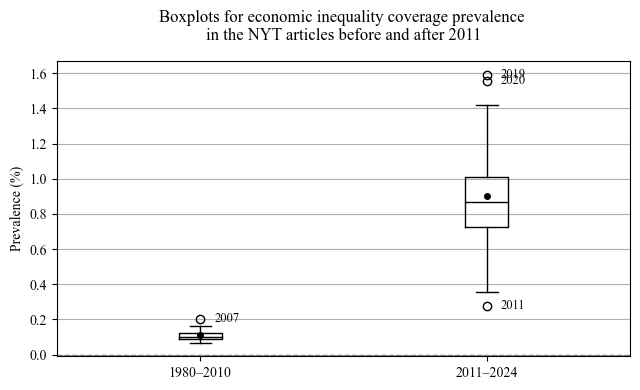

In [32]:
plot_gap_boxplot(
    df=comparison_df,
    col_name="article_proportion",
    pivot_year=2010,
    title="Boxplots for economic inequality coverage prevalence \nin the NYT articles before and after 2011",
    y_label="Prevalence (%)",
    output_path="graphs/nyt_prevalences_boxplot.png"
)


In [33]:
analyze_gap_statistics(comparison_df, col_name="article_proportion", year_col="year", pivot_year=2010)


One-sample t-tests (test if mean ≠ 0):
  Before 2010: t = 19.16, p = 0.0000
  After 2010:  t = 8.28, p = 0.0000

Two-sample Welch t-test:
  t = -7.26, p = 0.0000
  Mean diff = -0.79 (95% CI: -1.03, -0.56)

Confidence intervals for group means:
  Before 2010: Mean = 0.11, 95% CI = [0.10, 0.12]
  After 2010:  Mean = 0.90, 95% CI = [0.67, 1.13]

Cohen's d: -3.511


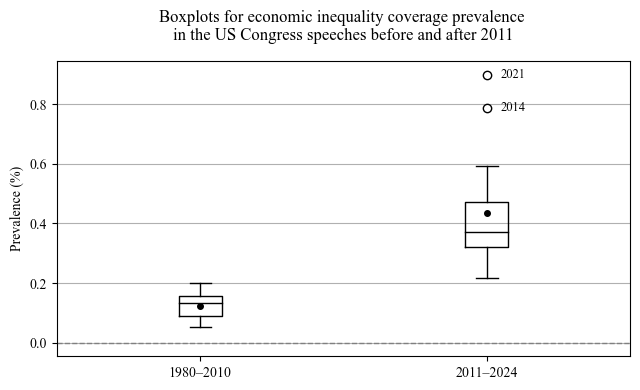

In [34]:
plot_gap_boxplot(
    df=comparison_df,
    col_name="speech_proportion",
    pivot_year=2010,
    title="Boxplots for economic inequality coverage prevalence \nin the US Congress speeches before and after 2011",
    y_label="Prevalence (%)",
    output_path="graphs/congress_prevalences_boxplot.png"
)


In [35]:
analyze_gap_statistics(comparison_df, col_name="speech_proportion", year_col="year", pivot_year=2010)


One-sample t-tests (test if mean ≠ 0):
  Before 2010: t = 16.26, p = 0.0000
  After 2010:  t = 8.16, p = 0.0000

Two-sample Welch t-test:
  t = -5.75, p = 0.0001
  Mean diff = -0.31 (95% CI: -0.43, -0.19)

Confidence intervals for group means:
  Before 2010: Mean = 0.13, 95% CI = [0.11, 0.14]
  After 2010:  Mean = 0.44, 95% CI = [0.32, 0.55]

Cohen's d: -2.686


Economic inequality objective measures

In [36]:
gini_data = pd.read_csv('economic_data/SIPOVGINIUSA.csv')
gini_data = gini_data.rename(columns={"SIPOVGINIUSA": "GINI_index"})

wealth_q = pd.read_csv('economic_data/dfa-networth-shares.csv')

congress_prop = pd.read_csv('economic_data/proportion_speeches_ineq_yearly.csv')
nyt_prop = pd.read_csv('economic_data/proportion_articles_ineq_yearly.csv')
congress_prop = congress_prop.rename(columns={"0": "congress_prop"})
nyt_prop = nyt_prop.rename(columns={"0": "nyt_prop"})

In [37]:
gini_data["year"] = pd.to_datetime(gini_data["observation_date"]).dt.year

In [38]:
#Weath accumulation information is in quartiles, average them
#add up both categories that regfer to top 1% (99 and 99.9 percentiles)

# Extract year from the Date column
wealth_q['year'] = wealth_q['Date'].str[:4].astype(int)

# Filter for the top 1% categories
top1_df = wealth_q[wealth_q['Category'].isin(['TopPt1', 'RemainingTop1'])]

# Aggregate net worth by year, taking the average over quarters
top1_yearly = (
    top1_df.groupby(['year', 'Category'])['Net worth']
    .mean()
    .unstack()
)

# Sum the two categories to get the total accumulation of the top 1%
top1_yearly = top1_yearly.reset_index()
top1_yearly['top1'] = top1_yearly[['TopPt1', 'RemainingTop1']].sum(axis=1)

Coverage and objective inequality

In [39]:
# Merge GINI and Top1 into one inequality DataFrame
ineq_df = pd.merge(
    gini_data[['year', 'GINI_index']],
    top1_yearly[['year', 'top1']],
    on='year',
    how='outer'  # combine all available years from both sources
)

# Now merge with the main comparison_df, keeping all rows from comparison_df
full_df = pd.merge(
    comparison_df,
    ineq_df,
    on='year',
    how='left'  # keep all rows from comparison_df, add GINI and top1 where available
)

In [40]:
def plot_ineq_coverage_static_full(full_df, output_path=""):
    plt.rcParams['font.family'] = 'Times New Roman'

    # Filter data from 1980 onward
    data = full_df[full_df['year'] >= 1980].copy()

    # Define US presidents and their party colors
    presidents = [
        (1981, 1989, "Republican", "Reagan"),
        (1989, 1993, "Republican", "Bush Sr."),
        (1993, 2001, "Democrat", "Clinton"),
        (2001, 2009, "Republican", "Bush Jr."),
        (2009, 2017, "Democrat", "Obama"),
        (2017, 2021, "Republican", "Trump"),
        (2021, 2024, "Democrat", "Biden")
    ]
    party_colors = {"Republican": "#C70039", "Democrat": "#1F77B4"}

    # Define major economic events
    events = {
        2007: "GR",
        2011: "OWS",
        2020: "COVID-19"
    }

    # Create figure
    fig_width_inch = 6.5
    fig_height_inch = 4
    fig, ax1 = plt.subplots(figsize=(fig_width_inch, fig_height_inch))

    # Plot primary data
    ax1.plot(data['year'], data['speech_proportion'], label='USA Congress', color='#77966D', linewidth=2)
    ax1.plot(data['year'], data['article_proportion'], label='NYT Articles', color='#FFB347', linewidth=2)
    ax1.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
    ax1.set_ylim(0, 3)
    ax1.set_xlim(1980, 2024)
    ax1.set_xticks(np.arange(1980, 2025, 4))
    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)


    # Plot secondary axes for GINI and top1
    ax2 = ax1.twinx()
    ax2.plot(data['year'], data['GINI_index'], label='Gini index', color='black', linestyle='dotted', linewidth=1.5)
    ax2.plot(data['year'], data['top1'], label='Top 1% wealth share', color='gray', linestyle='--', linewidth=1.5)
    ax2.set_ylabel('Gini index / Top 1%', fontsize=12, fontweight='bold')

    # Add presidential transitions and labels
    #for start, end, party, name in presidents:
    #    if start > 1980:
    #        ax1.axvline(x=start, color='black', linestyle=(0, (3, 5)), linewidth=1)
    #    ax1.text((start + end) / 2, 2.1, name, color=party_colors[party], ha='center', fontsize=9)

    # Add economic event lines
    #for year, label in events.items():
    #    ax1.axvline(x=year, color='grey', linestyle=(0, (1, 2)), linewidth=1.5)
    #    ax1.text(year, 2.65, label, ha='center', fontsize=10)

    # Titles and labels
    ax1.set_title(
        'Economic inequality yearly coverage percentages for the NYT, \nUSA Congress, Gini index and top 1% wealth share',
        fontsize=12, pad=50)
    ax1.set_xlabel('Year', fontsize=12, fontweight='bold')

    # Legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=2)

    # Aesthetics
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    # Save or show plot
    if output_path:
        output_path = output_path
        plt.savefig(output_path, bbox_inches='tight')
    plt.show()

"Static plotting function updated to include GINI and Top 1% on secondary axis."


'Static plotting function updated to include GINI and Top 1% on secondary axis.'

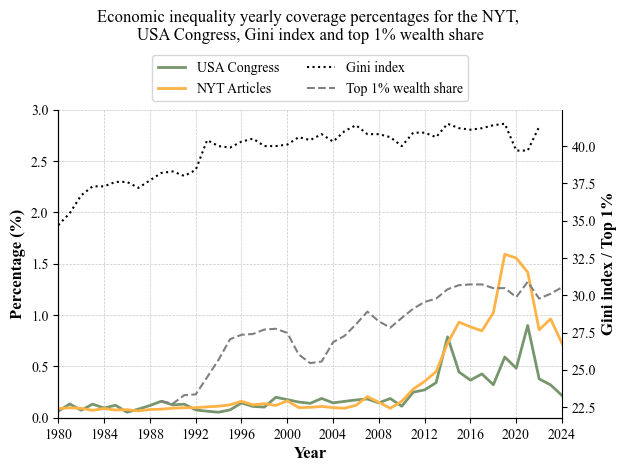

In [41]:
plot_ineq_coverage_static_full(full_df, output_path = 'graphs/coverage_econobj.png')

Correlations

In [42]:
def pearsonr_ci(x, y, alpha=0.05):
    r, _ = pearsonr(x, y)
    
    n = len(x)
    if n < 4:
        return r, np.nan, np.nan  # too few samples
    se = 1 / np.sqrt(n - 3)

    z = 0.5 * np.log((1 + r) / (1 - r)) # Calculate Fisher's z-transformation:
    z_crit = stats.norm.ppf(1 - alpha/2) #two tailed
    z_lower =  z - z_crit * se
    z_upper =  z + z_crit * se

    ci_lower = np.tanh(z_lower) # ci_lower2 = (np.exp(2 * z_lower) - 1) / (np.exp(2 * z_lower) + 1)
    ci_upper = np.tanh(z_upper) # ci_upper2 = (np.exp(2 * z_upper) - 1) / (np.exp(2 * z_upper) + 1)


    return r, ci_lower, ci_upper

In [43]:
# Compute correlation matrix with p-values
corr_col = ["GINI_index", "congress_prop", "nyt_prop", "year"]

gini_corr_data = gini_data.merge(congress_prop, on="year", how="inner").merge(nyt_prop, on="year", how="inner")

# Compute correlation matrix and p-values
corr_gini = gini_corr_data[corr_col].corr(method="pearson")
p_values_g = gini_corr_data[corr_col].corr(method=lambda x, y: stats.pearsonr(x, y)[1])

# Display results
print("Correlation Matrix:")
print(corr_gini)

print("\nP-values:")
print(p_values_g)

Correlation Matrix:
               GINI_index  congress_prop  nyt_prop      year
GINI_index       1.000000       0.438667  0.403593  0.838134
congress_prop    0.438667       1.000000  0.858158  0.734997
nyt_prop         0.403593       0.858158  1.000000  0.745953
year             0.838134       0.734997  0.745953  1.000000

P-values:
                 GINI_index  congress_prop      nyt_prop          year
GINI_index     1.000000e+00   3.255609e-03  7.279727e-03  2.359447e-12
congress_prop  3.255609e-03   1.000000e+00  1.923036e-13  1.998305e-08
nyt_prop       7.279727e-03   1.923036e-13  1.000000e+00  9.437875e-09
year           2.359447e-12   1.998305e-08  9.437875e-09  1.000000e+00


In [44]:
ci_results = []

for col1, col2 in combinations(corr_col, 2):
    x = gini_corr_data[col1].dropna()
    y = gini_corr_data[col2].dropna()
    # align both vectors by index in case of missing data
    df_pair = pd.DataFrame({col1: x, col2: y}).dropna()
    r, ci_low, ci_high = pearsonr_ci(df_pair[col1], df_pair[col2])
    ci_results.append({
        'var1': col1,
        'var2': col2,
        'r': round(r, 3),
        'CI lower': round(ci_low, 3),
        'CI upper': round(ci_high, 3)
    })

gini_ci_df = pd.DataFrame(ci_results)

In [45]:
gini_ci_df

,var1,var2,r,CI lower,CI upper
0,GINI_index,congress_prop,0.439,0.159,0.653
1,GINI_index,nyt_prop,0.404,0.117,0.628
2,GINI_index,year,0.838,0.719,0.910
3,congress_prop,nyt_prop,0.858,0.752,0.921
4,congress_prop,year,0.735,0.558,0.848
5,nyt_prop,year,0.746,0.574,0.855


In [46]:
corr_col = ["top1", "congress_prop", "nyt_prop", "year"]


# Merge datasets on "year"
wealth_corr_data = top1_yearly.merge(congress_prop, on="year", how="inner").merge(nyt_prop, on="year", how="inner")

# Compute correlation matrix and p-values
corr_wealth = wealth_corr_data[corr_col].corr(method="pearson")
p_values_w = wealth_corr_data[corr_col].corr(method=lambda x, y: stats.pearsonr(x, y)[1])

# Display results
print("Correlation Matrix:")
print(corr_wealth)

print("\nP-values:")
print(p_values_w)

Correlation Matrix:
                   top1  congress_prop  nyt_prop      year
top1           1.000000       0.669628  0.716701  0.904704
congress_prop  0.669628       1.000000  0.828116  0.696528
nyt_prop       0.716701       0.828116  1.000000  0.797219
year           0.904704       0.696528  0.797219  1.000000

P-values:
                       top1  congress_prop      nyt_prop          year
top1           1.000000e+00   7.960858e-06  8.807545e-07  3.760195e-14
congress_prop  7.960858e-06   1.000000e+00  4.598470e-10  2.380135e-06
nyt_prop       8.807545e-07   4.598470e-10  1.000000e+00  5.921431e-09
year           3.760195e-14   2.380135e-06  5.921431e-09  1.000000e+00


In [47]:
ci_results = []

for col1, col2 in combinations(corr_col, 2):
    x = wealth_corr_data[col1].dropna()
    y = wealth_corr_data[col2].dropna()
    # align both vectors by index in case of missing data
    df_pair = pd.DataFrame({col1: x, col2: y}).dropna()
    r, ci_low, ci_high = pearsonr_ci(df_pair[col1], df_pair[col2])
    ci_results.append({
        'var1': col1,
        'var2': col2,
        'r': round(r, 3),
        'CI lower': round(ci_low, 3),
        'CI upper': round(ci_high, 3)
    })

top1_ci_df = pd.DataFrame(ci_results)

In [48]:
top1_ci_df

,var1,var2,r,CI lower,CI upper
0,top1,congress_prop,0.670,0.437,0.818
1,top1,nyt_prop,0.717,0.508,0.846
2,top1,year,0.905,0.820,0.951
3,congress_prop,nyt_prop,0.828,0.686,0.909
4,congress_prop,year,0.697,0.477,0.834
5,nyt_prop,year,0.797,0.635,0.892


In [49]:
# Helper to query correlation regardless of column order
def format_corr_ci(r, low, high):
    return f"{r:.2f} ({low:.2f}, {high:.2f})"

def get_corr_ci(df, var_a, var_b):
    match = df[((df["var1"] == var_a) & (df["var2"] == var_b)) |
               ((df["var1"] == var_b) & (df["var2"] == var_a))].iloc[0]
    return format_corr_ci(match["r"], match["CI lower"], match["CI upper"])

# Build formatted table using robust matching
table_data = {
    "": ["NYT", "US Congress"],
    "GINI index": [
        get_corr_ci(gini_ci_df, "GINI_index", "nyt_prop"),
        get_corr_ci(gini_ci_df, "GINI_index", "congress_prop")
    ],
    "Top 1%": [
        get_corr_ci(top1_ci_df, "top1", "nyt_prop"),
        get_corr_ci(top1_ci_df, "top1", "congress_prop")
    ],
    "Year": [
        get_corr_ci(gini_ci_df, "year", "nyt_prop"),
        get_corr_ci(gini_ci_df, "year", "congress_prop")
    ]
}

ci_corr_table = pd.DataFrame(table_data)
ci_corr_table

,,GINI index,Top 1%,Year
0,NYT,"0.40 (0.12, 0.63)","0.72 (0.51, 0.85)","0.75 (0.57, 0.85)"
1,US Congress,"0.44 (0.16, 0.65)","0.67 (0.44, 0.82)","0.73 (0.56, 0.85)"


In [50]:
# Define the LaTeX table as a string
latex_table = "" 

# Add rows from the table_data DataFrame
for index, row in ci_corr_table.iterrows():
    latex_table += f"{row[0]} & {row[1]} & {row[2]} & {row[3]} \\\\\n"

# Define the output file path
output_txt_path = "economic_data/ci_corr_table_objineq.txt"

# Save the LaTeX table as a .txt file
with open(output_txt_path, "w") as file:
    file.write(latex_table)

C:\Users\agust\AppData\Local\Temp\ipykernel_20704\289443427.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

